# Optimize over List of Functions

In [ ]:
import numpy as np
from bound_rewards_g import compute_bound as compute_bound
from f_func import *
from lava_problem import main as lava_problem
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import gurobipy

In [ ]:
# Initialize
def g(x,c,func_list):
    # c and func_list should have matching dimensions
    y = 0
    for i in range (len(func_list)):
        y += c[i]*eval(func_list[i])(x)
    return y

# Different probabilities of sensor reporting correct state
p_correct_vals = np.linspace(0.01, 0.99, 20) 

# Different rewards for being in a non-lava/goal state
reward_xs = np.array([0.1]) 

#for reward_x in reward_xs:
reward_x = reward_xs[0]

bounds_f_inverse = []

#Setup for finding tightest bounds
#func_list = [ 'Kullback_Leibler', 'Total_Variation','Chi_Squared','Negative_Log']
#func_list = [ 'Kullback_Leibler', 'Negative_Log','Total_Variation', 'Chi_Squared', 'Jensen_Shannon','Squared_Hellinger_Distance','Neyman_Chi_Squared']
#func_list = [ 'Kullback_Leibler', 'Negative_Log','Total_Variation', 'Chi_Squared','Neyman_Chi_Squared']
#'Negative_Log',

#c01 = np.tile(np.array([0,1,0,0]),(7,1))
#c02 = np.tile(np.array([0.5,0.5,0.5,0.5]),(1,1))
#c03 = np.tile(np.array([0,0,0,1]),(1,1))
#c04 = np.tile(np.array([0.1,0.1,0.3,1]),(3,1))
#c05 = np.tile(np.array([1e-5,1e-5,1e-5,1]),(13,1))

#c0 = np.concatenate((c01,c02,c03,c02,c04,c05))
#c0 = np.concatenate((c01,c05))

ca = np.tile(np.array([1e-5,1e-5,1,1e-5,1e-5]),(5,1))
cb = np.tile(np.array([1e-5,1e-5,2,1e-5,1e-5]),(1,1))
cc = np.tile(np.array([1e-5,1e-5,1e-5,1e-5,2]),(4,1))
cd = np.tile(np.array([0.5,0.5,0.5,0.5,0.5]),(3,1))
ce = np.tile(np.array([1e-5,1e-5,1,1e-5,1e-5]),(4,1))
cf = np.tile(np.array([1e-5,1e-5,1e-5,1e-5,2]),(1,1))
cg = np.tile(np.array([0.5,0.5,0.5,0.5,0.5]),(2,1))


c0 = np.concatenate((ca,cb,cc,cd,ce,cf,cg))

def con(c_vec):
	return np.linalg.norm(c_vec)-1

def con1(c_vec):
    return list(c_vec-1e-5)

def con2(c_vec):
    return list(1-c_vec)

Nfeval=1
def callbackF(Xi):
    global Nfeval
    #print ('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}'.format(Nfeval,Xi[0],Xi[1],bounds(Xi)))
    print ('{0:4d}{1: 3.2f}{2: 3.2f}{3: 3.2f}{4: 3.2f}{5: 3.6f}{6: 3.6f}'.format(Nfeval,Xi[0],Xi[1],Xi[2],Xi[3],Xi[4],bounds(Xi)))
    Nfeval += 1

#cons = [{'type':'ineq','fun': con1},{'type':'eq','fun':con},{'type':'ineq','fun': con2}]
cons = [{'type':'ineq','fun': con1},{'type':'ineq','fun': con2}]

def bounds(c_vec):
    nx, nu, ny, T, p0, px_x, py_x, R, R0_expected = lava_problem(['--p_correct', str(p_correct), '--reward_x', str(reward_x)])
    ################################################################################


    ################################################################################
    # Compute f-inverse bound
    # t_start = time.time()
    bound_f_inverse = compute_bound(g,c_vec,func_list, nx, nu, ny, T, p0, px_x, py_x, R, R0_expected) 
    # t_end = time.time()
    bounds_f_inverse.append(bound_f_inverse)
    #print("Bound: ", bound_f_inverse)
    # print("Bound computation time: ", t_end - t_start)
    ################################################################################
    return bound_f_inverse


In [ ]:

p_correct = p_correct_vals[17]
#c = np.array([0.5,0.5,0.5,0.5,0.5])
c = np.array([1e-5,1e-5,1e-5,1e-5,2])
#c = np.array([1e-5,1e-5,1,1e-5,1e-5])
Nfeval=1
res1 = optimize.minimize(bounds,c, constraints = cons, callback=callbackF, options={'disp':True})


In [ ]:
# Loop
coefs = []
vals = []
results = []
for ind in range(17, 20):
#for p_correct in p_correct_vals:
	p_correct = p_correct_vals[ind]
	def bounds(c_vec):
		nx, nu, ny, T, p0, px_x, py_x, R, R0_expected = lava_problem(['--p_correct', str(p_correct), '--reward_x', str(reward_x)])
		bound_f_inverse = compute_bound(g,c_vec,func_list, nx, nu, ny, T, p0, px_x, py_x, R, R0_expected) 
		bounds_f_inverse.append(bound_f_inverse)
		return bound_f_inverse

	#ind = np.where(p_correct_vals == p_correct)[0][0]

	res = optimize.minimize(bounds,c0[ind], constraints = cons, callback=callbackF, options={'disp':True})
	results.append(res)
	coefs.append(res.x)
	vals.append(res.fun)


# Pick Tightest Bounds

In [ ]:
bounds_f_inverse = []
func_list = ['Kullback_Leibler', 'Negative_Log', 'Total_Variation', 'Chi_Squared', 'Jensen_Shannon', 'Squared_Hellinger_Distance','Neyman_Chi_Squared']

def tight_bound(p_correct):
    ################################################################################
    # Lava problem
    nx, nu, ny, T, p0, px_x, py_x, R, R0_expected = lava_problem(['--p_correct', str(p_correct), '--reward_x', str(reward_x)])
    ################################################################################
    
    bounds_tight = np.zeros(len(func_list))
    for i in range(len(func_list)):
        c_vec = np.zeros(len(func_list))
        c_vec[i]=1
        ################################################################################
        # Compute f-inverse bound
        bound_f_inverse = compute_bound(g,c_vec,func_list, nx, nu, ny, T, p0, px_x, py_x, R, R0_expected)
        bounds_tight[i]=bound_f_inverse
        ################################################################################
    
    bound_tight = np.amin(bounds_tight)
    fun = np.where(bounds_tight == bound_tight)[0][0]

    print("Bound: ", bound_tight, func_list[fun])
    return bound_tight, fun

for p_correct in p_correct_vals:
    bound_f_inverse = tight_bound(p_correct)
    bounds_f_inverse.append(bound_f_inverse)


# Plots

In [62]:
bds = []
for i in results:
    bds.append(i[1])
#bds = [4.10549890726847,5,5,3.6768940702048005,3.6768940702048,3.676894070204799,3.7181342298278213,3.859663124227767,3.923903566402169,3.9475951125023236,5,5,4.105327439930643,5,5,5,5,5,4.324995749999707]

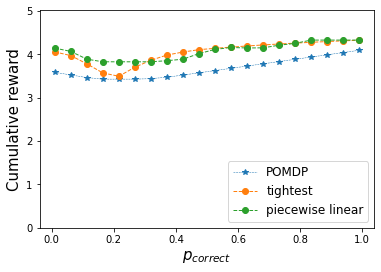

In [63]:
import matplotlib.pyplot as plt
# Plot POMDP v picked tightest bounds
opt_data = np.load("results/lava_problem_optimal_results.npz")
p_correct_vals = opt_data['p_correct_vals']
opt_values = opt_data['opt_values']

# Plot
fig, ax = plt.subplots()
ax.plot(p_correct_vals, opt_values, '*--', label='POMDP', linewidth=0.5)

data = np.load("tightest_bounds.npz")
bounds = data['bounds']
ax.plot(p_correct_vals, bounds, 'o--', label='tightest', linewidth=1) 

ax.plot(p_correct_vals, bds, 'o--', label = 'piecewise linear', linewidth = 1)

plt.xlabel('$p_{correct}$', fontsize=15)
plt.ylabel('Cumulative reward', fontsize=15)
plt.legend(fontsize=12, loc='lower right')
plt.ylim([0, 5.01])
plt.savefig('PLn=2.svg', dpi=200)
plt.show() 

In [ ]:
# Plot POMDP v optimized tightest bounds v KL bounds

opt_data = np.load("results/lava_problem_optimal_results.npz")
p_correct_vals = opt_data['p_correct_vals']
opt_values = opt_data['opt_values']

fig, ax = plt.subplots()
ax.plot(p_correct_vals, opt_values, '*--', label='POMDP', linewidth=0.5)
ax.plot(p_correct_vals,vals,'.--', label='Optimized Bounds', linewidth=1)

data = np.load("results/lava_problem_Kullback_Leibler_results_f.npz")
bounds = data['bounds']
ax.plot(p_correct_vals, bounds, '.--', label='KL', linewidth=1)

#data = np.load("tightest_bounds.npz")
#bounds = data['bounds']
#ax.plot(p_correct_vals, bounds, '.--', label='Tightest Bounds', linewidth=1)

plt.xlabel('$p_{correct}$', fontsize=15)
plt.ylabel('Cumulative reward', fontsize=15)
plt.legend(fontsize=12, loc='lower right')
plt.ylim([0, 5.01])
plt.savefig('Tight_Bounds_vs_KL_5.svg', dpi=200)
plt.show() 


# Piecewise Linear Function

In [89]:
import numpy as np
from bound_rewards_l import *
from lava_problem import main as lava_problem
import scipy.optimize as optimize
import matplotlib.pyplot as plt
# from multiprocessing import Pool
import cvxpy as cvx

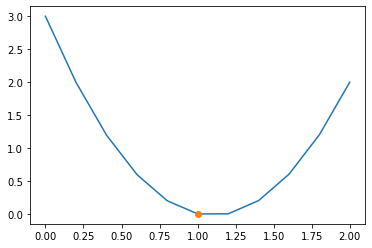

In [88]:
n=5
svec=[-5,-4,-3,-2,-1,0,1,2,3,4]

k = 1000
xt = np.linspace(0,2,k)
yt = np.linspace(0,2,k)


def l(x,n,svec):
    # x is the independent variable
    # n is the number of slices
    # svec is the slope vector with dimension (n,1), starting from 1 to 0 backwards
    intercept = [-s/n for s in svec]
    output = [0]*(2*n)
    for i in range(n):
        output[i] = svec[i]*(x-(i+1)/n)+sum(intercept[(i+1):n])
    for i in range(n,2*n):
        output[i] = svec[i]*(x-i/n)-sum(intercept[n:i])
    return cvx.max(cvx.vstack(output),axis=0)


for i in range(k):
    yt[i] = l(xt[i],n,svec).value
    
plt.plot(xt,yt)
plt.plot(1,0,'o')

In [90]:
n = 50 # 50 slices on interval [0,1]
svec = np.zeros(n) # set initial guesses to be 0

# Setups for lava problem
p_correct_vals = np.linspace(0.01, 0.99, 20) 
reward_xs = np.array([0.1]) 
reward_x = reward_xs[0]

# Constraint: from 0 to 2, each slope has to be larger
# So elements in the slope vector need to be in increasing order
def con(svec):
    out = []
    for i in range(len(svec)-1):
        out.append(svec[i+1]-svec[i])
    return out
def con1(svec):
    return l(0,n,svec)-1
cons = [{'type':'ineq','fun': con}]

# Print optimization progress
def callbackF(svec,status):
    #global Nfeval
    print (svec,bounds(svec))
    #Nfeval += 1


In [92]:
from dask.distributed import Client, progress
client = Client()
client

Client Scheduler: tcp://127.0.0.1:54522,Cluster Workers: 4 Cores: 8 Memory: 8.59 GB


In [93]:
import dask

n = 5 # n slices on interval [0,1]
svec = [0]*(2*n) # set initial guesses to be 0
def bounds(svec, p_correct = p_correct_vals[0]):
		nx, nu, ny, T, p0, px_x, py_x, R, R0_expected = lava_problem(['--p_correct', str(p_correct), '--reward_x', str(reward_x)])
		bound_f_inverse = compute_bound(l,n,svec, nx, nu, ny, T, p0, px_x, py_x, R, R0_expected) 
		return bound_f_inverse

def minimize(p_correct,s0):
	res = optimize.minimize(bounds,s0,method = 'trust-constr', constraints = cons, callback = callbackF, args = (p_correct), options={'disp':True})
	return[res.x, res.fun]

args = [(i) for i in p_correct_vals]
# fut = client.map(minimize,args)
futures = []
for p in args:
    future = client.submit(minimize,p)
    futures.append(future)

In [ ]:
svec = [0,0,0,0,0]
print(minimize(0.7836842105263158))

In [94]:
client.close()
del futures

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


In [33]:
# results5 = client.gather(futures)
results5 = [0]*20
for i in [0,3,4,5,6,7,8,9,12,18,19]:
    results5[i] = futures[i].result()

In [ ]:
n = 2 # n slices on interval [0,1]
svec = [0]*n # set initial guesses to be 0
def bounds(svec, p_correct = p_correct_vals[0]):
		nx, nu, ny, T, p0, px_x, py_x, R, R0_expected = lava_problem(['--p_correct', str(p_correct), '--reward_x', str(reward_x)])
		bound_f_inverse = compute_bound(l,n,svec, nx, nu, ny, T, p0, px_x, py_x, R, R0_expected) 
		return bound_f_inverse

def minimize(args):
	f,x,a = args
	res = optimize.minimize(f,x,method = 'trust-constr', constraints = cons, callback = callbackF, args = (a))
	return[res.x, res.fun]

args = [(bounds,svec,p_correct_vals[i]) for i in range(4)]
p = Pool(4)
print(p.map(minimize,args))


In [ ]:
p_correct_vals[0]

In [ ]:
n=2
svec = [-0.5,-0.5]
print(f_divergence(l,n,svec,np.array([0.4,0.6]),np.array([0.6,0.4])).value)
# cvx.kl_div(np.array([0.4,0.6]),np.array([0.6,0.4])).value
def f_divergence1(f,p,q):
    div = cvx.multiply(q,f(p/q))
    return div
def f(x):
    return 0.5*cvx.abs(x-1)
print(f_divergence1(f,np.array([0.4,0.6]),np.array([0.6,0.4])).value)
# cvx.multiply(0.4,l(0.6/0.4,n,svec)).value
p = np.array([0.4,0.6])
q = np.array([0.6,0.4])
print(cvx.multiply(q,l(p/q,n,svec)).value)
print(cvx.multiply(q,f(p/q)).value)
print(l(p/q,n,svec).value,f(p/q))


In [ ]:
from bound_rewards_l import compute_bound as compute_bound_l
from bound_rewards_f import compute_bound as compute_bound_f
p_correct = p_correct_vals[0]
nx, nu, ny, T, p0, px_x, py_x, R, R0_expected = lava_problem(['--p_correct', str(p_correct), '--reward_x', str(reward_x)])
bound_l= compute_bound_l(l,n,svec, nx, nu, ny, T, p0, px_x, py_x, R, R0_expected) 
bound_f= compute_bound_f(f, nx, nu, ny, T, p0, px_x, py_x, R, R0_expected) 
print(bound_l,bound_f)

In [ ]:
# Loop
coefs = []
vals = []
results = []
for ind in range(20):
#for p_correct in p_correct_vals:
	p_correct = p_correct_vals[ind]
	def bounds(svec):
		nx, nu, ny, T, p0, px_x, py_x, R, R0_expected = lava_problem(['--p_correct', str(p_correct), '--reward_x', str(reward_x)])
		bound_f_inverse = compute_bound(l,n,svec, nx, nu, ny, T, p0, px_x, py_x, R, R0_expected) 
		return bound_f_inverse

	res = optimize.minimize(bounds,svec, constraints = cons, callback=callbackF, options={'disp':True})
	results.append(res)
	coefs.append(res.x)
	vals.append(res.fun)


In [ ]:
np.savez('piecewiselinear.npz',reward_xs=reward_xs, p_correct_vals=p_correct_vals, slopes = coefs, bounds = vals, results = results)

In [ ]:
# Plot POMDP v picked tightest bounds
opt_data = np.load("results/lava_problem_optimal_results.npz")
p_correct_vals = opt_data['p_correct_vals']
opt_values = opt_data['opt_values']

# Plot
fig, ax = plt.subplots()
ax.plot(p_correct_vals, opt_values, '*--', label='POMDP', linewidth=0.5)

data = np.load("piecewiselinear.npz")
bounds = data['bounds']
ax.plot(p_correct_vals, bounds, 'o--', label='Piecewise-linear Functions', linewidth=1) 

plt.xlabel('$p_{correct}$', fontsize=15)
plt.ylabel('Cumulative reward', fontsize=15)
plt.legend(fontsize=12, loc='lower right')
plt.ylim([0, 5.01])
plt.savefig('piecewiselinear.svg', dpi=200)
plt.show() 

In [ ]:
x = np.array([0,1])
intercept = [0]*n
output = [0]*n
for i in range(n):
    intercept[i] = -svec[i]/n
    output[i] = svec[i]*(x-1+i/n)+sum(intercept[0:i])
cvx.max(cvx.vstack(output),axis=0).value

In [ ]:
cvx.vstack(output).value

In [ ]:
def square(x, a=1):
    return (x-a)**2+1

def minimize(args):
    f,x,a = args
    res = optimize.minimize(f, x, args = (a))
    return [res.x,res.fun]

# your a values
a = list(range(10))

# initial guess for all the x values
x = [25]*len(a)

args = [(square,x[i],a[i]) for i in range(10)]
p = Pool(4)
print(p.map(minimize,args))


In [34]:
print(results5)

[[array([13.25444505, -5.01946962, -5.01947713, -5.01947723, -5.01948808]), 4.10549890726847], 0, 0, [array([ 0.74362912,  0.39959574,  0.18895766, -0.01363215, -0.31363924]), 3.6768940702048005], [array([ 0.74362912,  0.39959574,  0.18895766, -0.01363215, -0.31363924]), 3.6768940702048], [array([ 0.74362912,  0.39959574,  0.18895767, -0.01363215, -0.31363924]), 3.676894070204799], [array([ 0.74362926,  0.39959578,  0.18895769, -0.01363219, -0.31363939]), 3.7181342298278213], [array([ 0.73986268,  0.44117645,  0.19157707, -0.00972343, -0.31559335]), 3.859663124227767], [array([ 1.99352432,  1.99341765, -0.03110151, -0.86097549, -2.22412347]), 3.923903566402169], [array([ 1.23204433,  1.23203498,  1.04861876, -0.74371116, -1.57130549]), 3.9475951125023236], 0, 0, [array([ 1.01827971,  1.01826236,  1.01817703, -0.51030393, -1.05845495]), 4.105327439930643], 0, 0, 0, 0, 0, [array([ 2.06804341e+00,  8.81918883e-01,  4.09938379e-05, -8.83023190e-01,
       -2.07088487e+00]), 4.3249957499997

In [68]:
svec = [13.25444505, -5.01946962, -5.01947713, -5.01947723, -5.01948808]
bounds(svec)

4.105498907243102